# PA3: Neural Network

In [54]:
# AI 201 - PA3
# Wilson Franz Bolo

# Note: Running the trainings for Networks A and B should take around 15 minutes
# Note: Running the last cell (learning curves across different values) should take another around 2 hours

# Libraries and Functions

In [30]:
# IMPORTING NECESSARY LIBRARIES

# to create the balanced dataset
from imblearn.over_sampling import SMOTE

# for the rest of PA 3
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time


# CREATING NECESSARY FUNCTIONS

# To one-hot encode (vectorize) labels
def one_hot_encode(label, num_class):
    return np.eye(num_class)[label-1]

# To reverse one-hot encode
def reverse_one_hot(vec_label):
    return np.argmax(vec_label)+1
     

# Activation functions and derivatives
def logistic(V):
    return 1 / (1 + np.exp(-2*V))

def der_logistic(Y):
    return 2*Y*(1-Y)
    
def hyper_tanh(V):
    return 1.716*np.tanh(V*2/3)

def der_hyper_tanh(Y):
    return ((2/3)/1.716) * (1.716 + Y) * (1.716 - Y)
    
def leaky_relu(V):
    return np.where(V > 0, V, 0.01 * V)

def der_leaky_relu(Y):
    return np.where(Y > 0, 1, 0.01)


# Forward Propagation
def forprop(x, weights, act_func):
    w1, b1, w2, b2, w3, b3 = weights['w1'], weights['b1'], weights['w2'], weights['b2'], weights['w3'], weights['b3']

    v1 = np.dot(w1, x) + b1
    if act_func[0] == 0:
        y1 = logistic(v1)
    elif act_func[0] == 1:
        y1 = hyper_tanh(v1)
    elif act_func[0] == 2:
        y1 = leaky_relu(v1)
    
    v2 = np.dot(w2, y1) + b2
    if act_func[1] == 0:
        y2 = logistic(v2)
    elif act_func[1] == 1:
        y2 = hyper_tanh(v2)
    elif act_func[1] == 2:
        y2 = leaky_relu(v2)
    
    v3 = np.dot(w3, y2) + b3
    if act_func[2] == 0:
        y3 = logistic(v3)
    elif act_func[2] == 1:
        y3 = hyper_tanh(v3)
    elif act_func[2] == 2:
        y3 = leaky_relu(v3)
    
    semi = {'v1': v1, 'v2': v2, 'v3': v3,'y1': y1, 'y2': y2, 'y3': y3}
    return semi


# Back Propagation
def backprop(x, d, weights, semi, eta, prev, alpha, act_func):
    w1, b1, w2, b2, w3, b3 = weights['w1'], weights['b1'], weights['w2'], weights['b2'], weights['w3'], weights['b3']
    pdw1, pdb1, pdw2, pdb2, pdw3, pdb3 = prev['dw1'], prev['db1'], prev['dw2'], prev['db2'], prev['dw3'], prev['db3']
    y1, y2, y3 = semi['y1'], semi['y2'], semi['y3']
    
    e = d - y3

    if act_func[2] == 0:
        d3 = e * der_logistic(y3)
    elif act_func[2] == 1:
        d3 = e * der_hyper_tanh(y3)
    elif act_func[2] == 2:
        d3 = e * der_leaky_relu(y3)
    dw3 = alpha * pdw3 + eta * np.dot(d3.reshape(-1,1), y2.reshape(-1,1).T)
    db3 = alpha * pdb3 + eta * d3 * 1
    
    if act_func[1] == 0:
        d2 = der_logistic(y2) * np.dot(w3.T, d3)
    elif act_func[1] == 1:
        d2 = der_hyper_tanh(y2) * np.dot(w3.T, d3)
    elif act_func[1] == 2:
        d2 = der_leaky_relu(y2) * np.dot(w3.T, d3)
    dw2 = alpha * pdw2 + eta * np.dot(d2.reshape(-1,1), y1.reshape(-1,1).T)
    db2 = alpha * pdb2 + eta * d2 * 1
    
    if act_func[0] == 0:
        d1 = der_logistic(y1) * np.dot(w2.T, d2)
    elif act_func[0] == 1:
        d1 = der_hyper_tanh(y1) * np.dot(w2.T, d2)
    elif act_func[0] == 2:
        d1 = der_leaky_relu(y1) * np.dot(w2.T, d2)
    dw1 = alpha * pdw1 + eta * np.dot(d1.reshape(-1,1), x.reshape(-1,1).T)
    db1 = alpha * pdb1 + eta * d1 * 1
    
    dw = {'e': e, 'dw1': dw1, 'dw2': dw2, 'dw3': dw3, 'db1': db1, 'db2': db2, 'db3': db3}
    return dw

    
# Calculating the required metrics
def metrics(actual, predicted, return_values=False):
    actual = np.array(actual)
    predicted = np.array(predicted)
    num_classes = 8
    
    # Initialize metrics
    precision, recall, f1_score = [], [], []
    tp_total, fp_total, fn_total, tn_total = 0, 0, 0, 0  # For MCC and accuracy

    # Confusion matrix
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion_matrix[i, j] = np.sum((actual == i+1) & (predicted == j+1))

    for c in range(num_classes):
        # True Positives, False Positives, False Negatives, True Negatives
        tp = np.sum((predicted == c+1) & (actual == c+1))
        fp = np.sum((predicted == c+1) & (actual != c+1))
        fn = np.sum((predicted != c+1) & (actual == c+1))
        tn = np.sum((predicted != c+1) & (actual != c+1))

        # For MCC calculation
        tp_total += tp
        fp_total += fp
        fn_total += fn
        tn_total += tn

        # Avoid division by zero
        p = tp / (tp + fp) if tp + fp != 0 else 0
        r = tp / (tp + fn) if tp + fn != 0 else 0
        f1 = 2 * p * r / (p + r) if p + r != 0 else 0

        precision.append(p)
        recall.append(r)
        f1_score.append(f1)

    # Print per-class metrics
    for c in range(num_classes):
        print(f"Class {c+1}: Precision={precision[c]:.4f}, Recall={recall[c]:.4f}, F1-Score={f1_score[c]:.4f}")

    # Mean-averaged F1 Score
    mean_f1 = np.mean(f1_score)
    print(f"\nMean-Averaged F1 Score: {mean_f1:.4f}")

    # Accuracy Calculation
    accuracy = (tp_total + tn_total) / (tp_total + tn_total + fp_total + fn_total)
    print(f"Accuracy: {accuracy:.4f}")

    # MCC Calculation
    mcc_numerator = (tp_total * tn_total) - (fp_total * fn_total)
    mcc_denominator = np.sqrt(tp_total + fp_total) * np.sqrt(tp_total + fn_total) * np.sqrt(tn_total + fp_total) * np.sqrt(tn_total + fn_total)
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Tick marks and labels
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))

    # Display values in the matrix
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(confusion_matrix[i, j]),
                     ha="center", va="center",
                     color="black" if confusion_matrix[i, j] < np.max(confusion_matrix) / 2 else "white")
    
    plt.xticks(ticks=np.arange(8), labels=np.arange(1, 9))
    plt.yticks(ticks=np.arange(8), labels=np.arange(1, 9))

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # Return metrics if requested
    if return_values:
        return {
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
            "mean_f1": mean_f1,
            "accuracy": accuracy,
            "mcc": mcc,
            "confusion_matrix": confusion_matrix
        }

# Saving the metrics to a CSV file
def save_metrics(metrics_dict, filename="metrics.csv"):
    # Create DataFrame for class-specific metrics
    num_classes = len(metrics_dict["precision"])
    df_metrics = pd.DataFrame({
        "Class": range(1, num_classes + 1),
        "Precision": metrics_dict["precision"],
        "Recall": metrics_dict["recall"],
        "F1-Score": metrics_dict["f1_score"]
    })

    # Add overall metrics
    df_overall = pd.DataFrame({
        "Class": ["Overall"],
        "Precision": ["-"],
        "Recall": ["-"],
        "F1-Score": [metrics_dict["mean_f1"]],
        "Accuracy": [metrics_dict["accuracy"]],
        "MCC": [metrics_dict["mcc"]]
    })

    # Concatenate metrics
    df_final = pd.concat([df_metrics, df_overall], ignore_index=True)

    # Save metrics first
    df_final.to_csv(filename, index=False)

    # Prepare confusion matrix
    cm_df = pd.DataFrame(metrics_dict["confusion_matrix"])
    cm_df.index.name = "Actual\\Predicted"

    # Append confusion matrix to the same CSV
    with open(filename, "a") as f:
        f.write("\nConfusion Matrix\n")
        cm_df.to_csv(f)

# Initial Steps: Balancing Dataset and Random Partition

In [32]:
%%time

# Load the dataset
file_data = "data.csv"
data = pd.read_csv(file_data, header = None)
data = np.array(data)

# Load the dataset labels
file_label = "data_labels.csv"
data_label = pd.read_csv(file_label, header = None)
data_label = np.array(data_label)

# Load the test set
file_test = "test_set.csv"
test = pd.read_csv(file_test, header = None)
test = np.array(test)

# Balancing the dataset
rand_seed = 1
oversample = SMOTE(random_state=rand_seed)
X, y = oversample.fit_resample(data, data_label)
X, y = np.array(X), np.array(y)
Y = one_hot_encode(y, 8) # Vectorizing the label

# Combining the input and output vectors into a dictionary
new_data = {i: {'label': label, 'features': features} for i, (label, features) in enumerate(zip(Y, X))}

# Split data into train and validation
val_size = 800
keys = list(new_data.keys())
random.Random(rand_seed).shuffle(keys) 
train_keys, val_keys = keys[val_size:], keys[:val_size]
train_dict = {k: new_data[k] for k in train_keys}
val_dict = {k: new_data[k] for k in val_keys}


# Saving into CSV files the training and validation sets

training_set, training_labels = [], []
# Training Set
for k, v in train_dict.items():
    training_set.append(v['features'])
    training_labels.append(reverse_one_hot(v['label']))
train_df, train_ldf = pd.DataFrame(training_set), pd.DataFrame(training_labels)
train_df.to_csv('training_set.csv', index = None, header = None)
train_ldf.to_csv('training_labels.csv', index = None, header = None)

validation_set, validation_labels  = [], []
# Validation Set
for k, v in val_dict.items():
    validation_set.append(v['features'])
    validation_labels.append(reverse_one_hot(v['label']))
validation_df, validation_ldf = pd.DataFrame(validation_set), pd.DataFrame(validation_labels)
validation_df.to_csv('validation_set.csv', index = None, header = None)
validation_ldf.to_csv('validation_labels.csv', index = None, header = None)

CPU times: total: 9.36 s
Wall time: 6.66 s


In [33]:
# To show the distribution of each class for the training and validation set
v_class_counts = {}
t_class_counts = {}

# Iterate through val_dict and count occurrences
for entry in val_dict.values():
    label = np.argmax(entry['label'])+1
    v_class_counts[label] = v_class_counts.get(label, 0) + 1

# Iterate through train_dict and count occurrences
for entry in train_dict.values():
    label = np.argmax(entry['label'])+1
    t_class_counts[label] = t_class_counts.get(label, 0) + 1

t = sorted(list(t_class_counts.keys()))
v = sorted(list(v_class_counts.keys()))

class_counts_t = {k: t_class_counts[k] for k in t}
class_counts_v = {k: v_class_counts[k] for k in v}

print("Class distribution in validation set:", class_counts_v)
print("Class distribution in training set:", class_counts_t)

Class distribution in validation set: {1: 101, 2: 92, 3: 99, 4: 88, 5: 99, 6: 111, 7: 97, 8: 113}
Class distribution in training set: {1: 1524, 2: 1533, 3: 1526, 4: 1537, 5: 1526, 6: 1514, 7: 1528, 8: 1512}


# Network A

Epoch = 1: Training SSE: 0.11118027214030979
Epoch = 2: Training SSE: 0.1078280721232449
Epoch = 3: Training SSE: 0.09401100928352421
Epoch = 4: Training SSE: 0.0889848854187505
Epoch = 5: Training SSE: 0.0880197485409574
Epoch = 6: Training SSE: 0.08764447691243278
Epoch = 7: Training SSE: 0.08739662667671294
Epoch = 8: Training SSE: 0.08672385518254226
Epoch = 9: Training SSE: 0.07843913215691661
Epoch = 10: Training SSE: 0.06297526742510157
Epoch = 11: Training SSE: 0.059393514907002856
Epoch = 12: Training SSE: 0.05385591589195293
Epoch = 13: Training SSE: 0.0496177518060293
Epoch = 14: Training SSE: 0.04453121452304594
Epoch = 15: Training SSE: 0.03956335469565575
Epoch = 16: Training SSE: 0.03638169827981211
Epoch = 17: Training SSE: 0.033038589584566076
Epoch = 18: Training SSE: 0.030073835429135623
Epoch = 19: Training SSE: 0.02745839471206723
Epoch = 20: Training SSE: 0.02483438890202166
Epoch = 21: Training SSE: 0.022909989656779296
Epoch = 22: Training SSE: 0.021093764500656

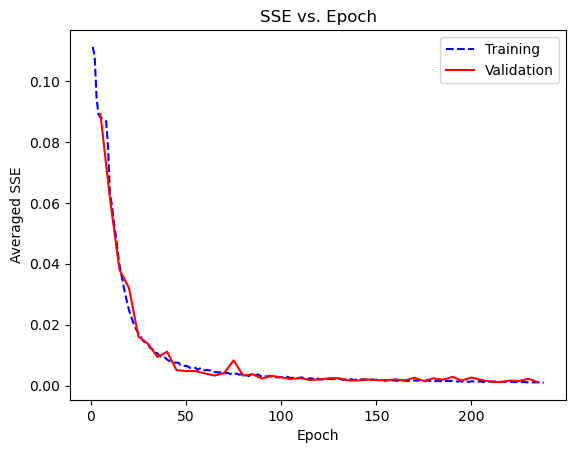

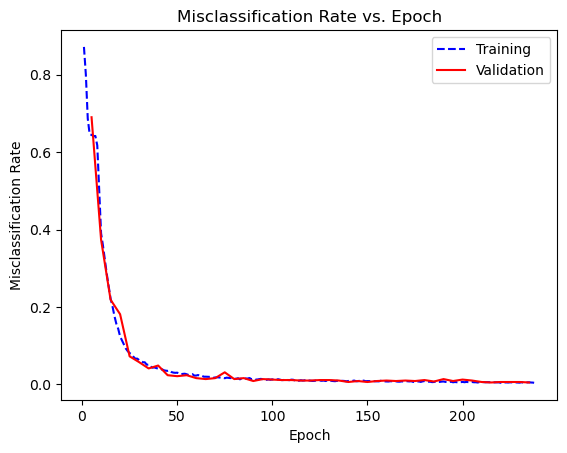

Class 1: Precision=1.0000, Recall=0.9901, F1-Score=0.9950
Class 2: Precision=0.9787, Recall=1.0000, F1-Score=0.9892
Class 3: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 4: Precision=1.0000, Recall=0.9886, F1-Score=0.9943
Class 5: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 6: Precision=0.9911, Recall=1.0000, F1-Score=0.9955
Class 7: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 8: Precision=0.9911, Recall=0.9823, F1-Score=0.9867

Mean-Averaged F1 Score: 0.9951
Accuracy: 0.9988
Matthews Correlation Coefficient (MCC): 0.9943


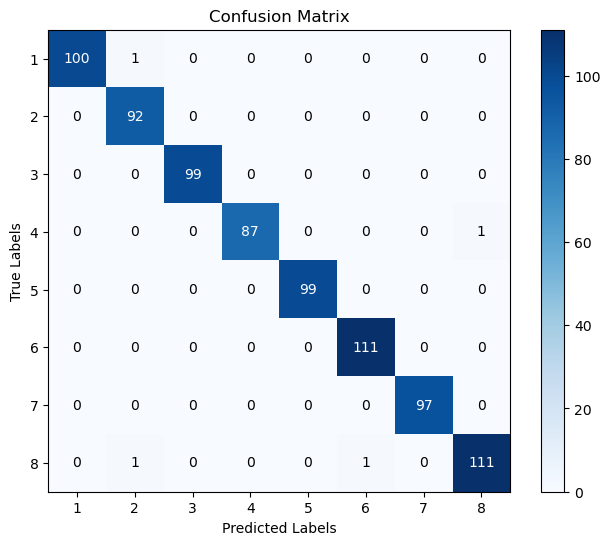

CPU times: total: 54min 34s
Wall time: 9min 11s


In [35]:
%%time

# Hard Code Inputs
rand_seed = 1 # randomization seed
eta = 0.01 # learning rate
alpha = 0.9 # momentum constant
act_func = [1, 1, 0] # activation functions for each layer -- 0: logistics; 1: hyperbolic tangent; 2: leaky relu
batch_size = 8 # mini batch size
hidden1_size = 100 # hidden layer 1 size
hidden2_size = 50 # hiddeen layer 2 size

train_size, val_size = len(train_keys), len(val_keys)
overall_count = 1
SSE_tr, SSE_val, MisClass_val, MisClass_tr, timer = {}, {}, {}, {}, {}

# Initialize
np.random.seed(rand_seed)
input_size = X.shape[1]
output_size = Y.shape[1]
weights = {
    'w1' : np.random.rand(hidden1_size, input_size)*0.01,
    'b1' : np.random.rand(hidden1_size,)*0.01,
    'w2' : np.random.rand(hidden2_size, hidden1_size)*0.01,
    'b2' : np.random.rand(hidden2_size,)*0.01,
    'w3' : np.random.rand(output_size, hidden2_size)*0.01,
    'b3' : np.random.rand(output_size,)*0.01,
    }

# Training
epoch, batch, err, val_err = 1, 0, 0, 0
t_counter, v_counter = 0, 0
sum_dw_db = {}
prev_SSE = 1
prev = {
    'dw1': np.zeros_like(weights['w1']),
    'db1': np.zeros_like(weights['b1']),
    'dw2': np.zeros_like(weights['w2']),
    'db2': np.zeros_like(weights['b2']),
    'dw3': np.zeros_like(weights['w3']),
    'db3': np.zeros_like(weights['b3']),
    }

while prev_SSE > 0.001:

    # Start the timer
    start_time = time.time()
    actual, predicted = [], []

    for ki, value in train_dict.items():
        x = value['features']
        d = value['label']

        # Forward and Backpropagation
        forward = forprop(x, weights, act_func)
        back = backprop(x, d, weights, forward, eta, prev, alpha, act_func)
        err += np.mean(back['e']**2)
        prev = back

        # Storing the delta values of the weights
        for k, v in back.items():
            if k not in sum_dw_db:
                sum_dw_db[k] = v
            else:
                sum_dw_db[k] += v

        # Updating the weights
        batch += 1
        if batch == batch_size:
            dw1, db1, dw2, db2, dw3, db3 = sum_dw_db['dw1'], sum_dw_db['db1'], sum_dw_db['dw2'], sum_dw_db['db2'], sum_dw_db['dw3'], sum_dw_db['db3']
            w1, b1, w2, b2, w3, b3 = weights['w1'], weights['b1'], weights['w2'], weights['b2'], weights['w3'], weights['b3']
            sum_dw_db = {}
                                    
            weights = {
                'w1' : w1 + dw1 * (1/batch),
                'b1' : b1 + db1 * (1/batch),
                'w2' : w2 + dw2 * (1/batch),
                'b2' : b2 + db2 * (1/batch),
                'w3' : w3 + dw3 * (1/batch),
                'b3' : b3 + db3 * (1/batch)
                }
            batch = 0
        
        act = reverse_one_hot(d)
        pred = reverse_one_hot(forward['y3'])
        t_counter += (pred != act) + 0
        
    # Validation calculations
    for k, v in val_dict.items():
        x = v['features']
        d = v['label']

        # Forward and Error Calculation
        forward = forprop(x, weights, act_func)
        val_e = d - forward['y3']
        val_err += np.mean(val_e**2)

        # Misclassification Calculation
        act = reverse_one_hot(d)
        pred = reverse_one_hot(forward['y3'])
        actual.append(act)
        predicted.append(pred)
        v_counter += (pred != act) + 0

    # Record validation values for every 5th epoch
    if epoch % 5 == 0:
        SSE_val[epoch] = val_err/val_size
        MisClass_val[epoch] = v_counter/val_size
        
    val_err, v_counter = 0, 0

    
    # Recording the average SSE and misclassification rate for the epoch and resetting        
    SSE_tr[epoch] = err/train_size
    MisClass_tr[epoch] = t_counter/train_size
    prev_SSE = err/train_size
    err, t_counter = 0, 0
    
    
    # Reshuffling the training data for the next epoch
    random.Random(rand_seed).shuffle(train_keys) 
    train_d = {k: train_dict[k] for k in train_keys}
    train_dict = train_d
    rand_seed += 1
    
    print(f"Epoch = {epoch}: Training SSE: {prev_SSE}")
    if epoch == 300: # early stopping criterion
        break

    # Stop the timer
    end_time = time.time()
    timer[epoch] = end_time - start_time
    epoch += 1


# Plotting the values:
            
plt.figure()
plt.plot(list(SSE_tr.keys()), list(SSE_tr.values()), label = "Training", color = "blue", linestyle = "dashed")
plt.plot(list(SSE_val.keys()), list(SSE_val.values()), label = "Validation", color = "red")
plt.xlabel('Epoch')
plt.ylabel('Averaged SSE')
plt.title('SSE vs. Epoch')
plt.legend()

plt.figure()
plt.plot(list(MisClass_tr.keys()), list(MisClass_tr.values()), label = "Training", color = "blue", linestyle = "dashed")
plt.plot(list(MisClass_val.keys()), list(MisClass_val.values()), label = "Validation", color = "red")
plt.xlabel('Epoch')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. Epoch')
plt.legend()

plt.show()

# Calculating the performance metrics of the validation set at the last epoch, and saving into a CSV file
actual_A, predicted_A = actual, predicted
metrics_A = metrics(actual, predicted, return_values = True)
save_metrics(metrics_A, filename="metrics_A.csv")

# Saving into CSV file the trained weights
weights_Alist = []
weights_A = weights
for key, value in weights_A.items():
    flat_values = value.flatten() 
    for idx, val in enumerate(flat_values):
        weights_Alist.append({'weight_name': key, 'index': idx+1, 'values': val})

df = pd.DataFrame(weights_Alist)
df.to_csv('trained_weights_A.csv', index = None)
# Format: column 1: weight (w1, b1, ..., b3); column 2: index; column 3: values

Epoch 1 to 2: -3.02% change
Epoch 2 to 3: -12.81% change
Epoch 3 to 4: -5.35% change
Epoch 4 to 5: -1.08% change
Epoch 5 to 6: -0.43% change
Epoch 6 to 7: -0.28% change
Epoch 7 to 8: -0.77% change
Epoch 8 to 9: -9.55% change
Epoch 9 to 10: -19.71% change
Epoch 10 to 11: -5.69% change
Epoch 11 to 12: -9.32% change
Epoch 12 to 13: -7.87% change
Epoch 13 to 14: -10.25% change
Epoch 14 to 15: -11.16% change
Epoch 15 to 16: -8.04% change
Epoch 16 to 17: -9.19% change
Epoch 17 to 18: -8.97% change
Epoch 18 to 19: -8.70% change
Epoch 19 to 20: -9.56% change
Epoch 20 to 21: -7.75% change
Epoch 21 to 22: -7.93% change
Epoch 22 to 23: -6.90% change
Epoch 23 to 24: -7.24% change
Epoch 24 to 25: -5.12% change
Epoch 25 to 26: -4.69% change
Epoch 26 to 27: -8.48% change
Epoch 27 to 28: -4.87% change
Epoch 28 to 29: -2.62% change
Epoch 29 to 30: -3.65% change
Epoch 30 to 31: -7.21% change
Epoch 31 to 32: -3.94% change
Epoch 32 to 33: -0.88% change
Epoch 33 to 34: -8.38% change
Epoch 34 to 35: -2.41% 

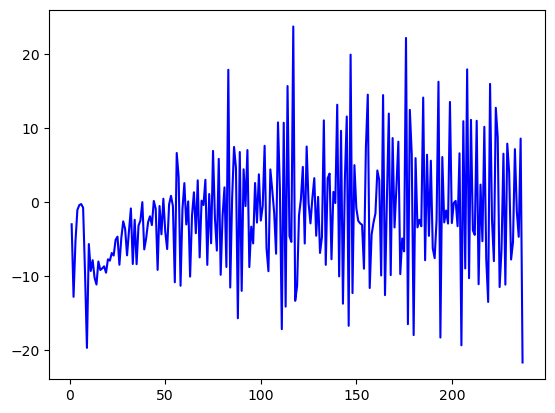

In [36]:
# For another perspective, to show the change in SSE per epoch
sse_values_A = list(SSE_tr.values())

# Calculate percent change
percent_changes_A = []
for i in range(1, len(sse_values_A)):
    prev_sse = sse_values_A[i - 1]
    curr_sse = sse_values_A[i]
    percent_change = ((curr_sse - prev_sse) / prev_sse) * 100
    percent_changes_A.append(percent_change)

# Display results
for epoch, change in enumerate(percent_changes_A, start=1):
    print(f"Epoch {epoch} to {epoch+1}: {change:.2f}% change")

plt.figure()
plt.plot(range(1, len(sse_values_A)), percent_changes_A, color = "blue")
plt.show()

# Network B

Epoch = 1: Training SSE: 0.11137067196619099
Epoch = 2: Training SSE: 0.10753203178054271
Epoch = 3: Training SSE: 0.09599813125827912
Epoch = 4: Training SSE: 0.08959881614860385
Epoch = 5: Training SSE: 0.08829932028744918
Epoch = 6: Training SSE: 0.08732301814235668
Epoch = 7: Training SSE: 0.08603843404200148
Epoch = 8: Training SSE: 0.08464217131984035
Epoch = 9: Training SSE: 0.08272844218063333
Epoch = 10: Training SSE: 0.07811033396723753
Epoch = 11: Training SSE: 0.06824000679411787
Epoch = 12: Training SSE: 0.0566490082938303
Epoch = 13: Training SSE: 0.047749743765383344
Epoch = 14: Training SSE: 0.040617676136313285
Epoch = 15: Training SSE: 0.03613396937317591
Epoch = 16: Training SSE: 0.03269976225234218
Epoch = 17: Training SSE: 0.029546129318108086
Epoch = 18: Training SSE: 0.025772882884913324
Epoch = 19: Training SSE: 0.02174340480084607
Epoch = 20: Training SSE: 0.018952699444856863
Epoch = 21: Training SSE: 0.01680438343244309
Epoch = 22: Training SSE: 0.01573810460

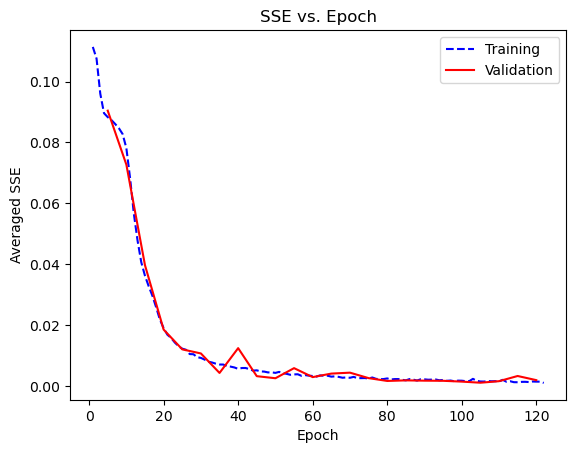

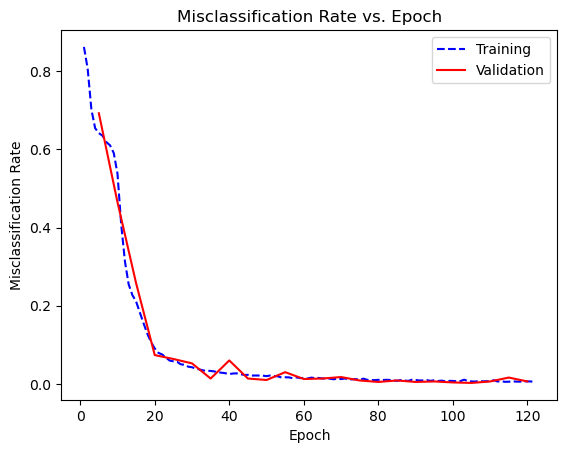

Class 1: Precision=1.0000, Recall=0.9901, F1-Score=0.9950
Class 2: Precision=0.9891, Recall=0.9891, F1-Score=0.9891
Class 3: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 4: Precision=1.0000, Recall=0.9886, F1-Score=0.9943
Class 5: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 6: Precision=0.9911, Recall=1.0000, F1-Score=0.9955
Class 7: Precision=1.0000, Recall=1.0000, F1-Score=1.0000
Class 8: Precision=0.9912, Recall=1.0000, F1-Score=0.9956

Mean-Averaged F1 Score: 0.9962
Accuracy: 0.9991
Matthews Correlation Coefficient (MCC): 0.9957


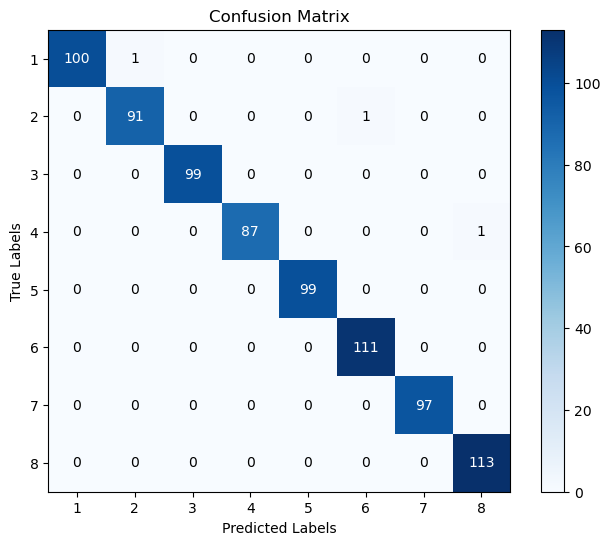

CPU times: total: 28min 47s
Wall time: 4min 52s


In [38]:
%%time

# Hard Code Inputs
rand_seed = 1 # randomization seed
eta = 0.01 # learning rate
alpha = 0.9 # momentum constant
act_func = [2, 2, 0] # activation functions for each layer -- 0: logistics; 1: hyperbolic tangent; 2: leaky relu
batch_size = 8 # mini batch size
hidden1_size = 100 # hidden layer 1 size
hidden2_size = 50 # hiddeen layer 2 size

train_size, val_size = len(train_keys), len(val_keys)
overall_count = 1
SSE_tr, SSE_val, MisClass_val, MisClass_tr, timer = {}, {}, {}, {}, {}

# Initialize
np.random.seed(rand_seed)
input_size = X.shape[1]
output_size = Y.shape[1]
weights = {
    'w1' : np.random.rand(hidden1_size, input_size)*0.01,
    'b1' : np.random.rand(hidden1_size,)*0.01,
    'w2' : np.random.rand(hidden2_size, hidden1_size)*0.01,
    'b2' : np.random.rand(hidden2_size,)*0.01,
    'w3' : np.random.rand(output_size, hidden2_size)*0.01,
    'b3' : np.random.rand(output_size,)*0.01,
    }

# Training
epoch, batch, err, val_err = 1, 0, 0, 0
t_counter, v_counter = 0, 0
sum_dw_db = {}
prev_SSE = 1
prev = {
    'dw1': np.zeros_like(weights['w1']),
    'db1': np.zeros_like(weights['b1']),
    'dw2': np.zeros_like(weights['w2']),
    'db2': np.zeros_like(weights['b2']),
    'dw3': np.zeros_like(weights['w3']),
    'db3': np.zeros_like(weights['b3']),
    }

while prev_SSE > 0.001:

    # Start the timer
    start_time = time.time()
    actual, predicted = [], []

    for ki, value in train_dict.items():
        x = value['features']
        d = value['label']

        # Forward and Backpropagation
        forward = forprop(x, weights, act_func)
        back = backprop(x, d, weights, forward, eta, prev, alpha, act_func)
        err += np.mean(back['e']**2)
        prev = back

        # Storing the delta values of the weights
        for k, v in back.items():
            if k not in sum_dw_db:
                sum_dw_db[k] = v
            else:
                sum_dw_db[k] += v

        # Updating the weights
        batch += 1
        if batch == batch_size:
            dw1, db1, dw2, db2, dw3, db3 = sum_dw_db['dw1'], sum_dw_db['db1'], sum_dw_db['dw2'], sum_dw_db['db2'], sum_dw_db['dw3'], sum_dw_db['db3']
            w1, b1, w2, b2, w3, b3 = weights['w1'], weights['b1'], weights['w2'], weights['b2'], weights['w3'], weights['b3']
            sum_dw_db = {}
                                    
            weights = {
                'w1' : w1 + dw1 * (1/batch),
                'b1' : b1 + db1 * (1/batch),
                'w2' : w2 + dw2 * (1/batch),
                'b2' : b2 + db2 * (1/batch),
                'w3' : w3 + dw3 * (1/batch),
                'b3' : b3 + db3 * (1/batch)
                }
            batch = 0
        
        act = reverse_one_hot(d)
        pred = reverse_one_hot(forward['y3'])
        t_counter += (pred != act) + 0
        
    # Validation calculations
    for k, v in val_dict.items():
        x = v['features']
        d = v['label']

        # Forward and Error Calculation
        forward = forprop(x, weights, act_func)
        val_e = d - forward['y3']
        val_err += np.mean(val_e**2)

        # Misclassification Calculation
        act = reverse_one_hot(d)
        pred = reverse_one_hot(forward['y3'])
        actual.append(act)
        predicted.append(pred)
        v_counter += (pred != act) + 0

    # Record validation values for every 5th epoch
    if epoch % 5 == 0:
        SSE_val[epoch] = val_err/val_size
        MisClass_val[epoch] = v_counter/val_size
        
    val_err, v_counter = 0, 0

    
    # Recording the average SSE and misclassification rate for the epoch and resetting        
    SSE_tr[epoch] = err/train_size
    MisClass_tr[epoch] = t_counter/train_size
    prev_SSE = err/train_size
    err, t_counter = 0, 0
    
    
    # Reshuffling the training data for the next epoch
    random.Random(rand_seed).shuffle(train_keys) 
    train_d = {k: train_dict[k] for k in train_keys}
    train_dict = train_d
    rand_seed += 1
    
    print(f"Epoch = {epoch}: Training SSE: {prev_SSE}")
    if epoch == 300: # early stopping criterion
        break

    # Stop the timer
    end_time = time.time()
    timer[epoch] = end_time - start_time
    epoch += 1


# Plotting the values:
            
plt.figure()
plt.plot(list(SSE_tr.keys()), list(SSE_tr.values()), label = "Training", color = "blue", linestyle = "dashed")
plt.plot(list(SSE_val.keys()), list(SSE_val.values()), label = "Validation", color = "red")
plt.xlabel('Epoch')
plt.ylabel('Averaged SSE')
plt.title('SSE vs. Epoch')
plt.legend()

plt.figure()
plt.plot(list(MisClass_tr.keys()), list(MisClass_tr.values()), label = "Training", color = "blue", linestyle = "dashed")
plt.plot(list(MisClass_val.keys()), list(MisClass_val.values()), label = "Validation", color = "red")
plt.xlabel('Epoch')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. Epoch')
plt.legend()

plt.show()

# Calculating the performance metrics of the validation set at the last epoch, and saving into a CSV file
actual_B, predicted_B = actual, predicted
metrics_B = metrics(actual, predicted, return_values = True)
save_metrics(metrics_B, filename="metrics_B.csv")

# Saving into CSV file the trained weights
weights_Blist = []
weights_B = weights
for key, value in weights_B.items():
    flat_values = value.flatten() 
    for idx, val in enumerate(flat_values):
        weights_Blist.append({'weight_name': key, 'index': idx+1, 'values': val})

df = pd.DataFrame(weights_Blist)
df.to_csv('trained_weights_B.csv', index = None)
# Format: column 1: weight (w1, b1, ..., b3); column 2: index; column 3: values

Epoch 1 to 2: -3.45% change
Epoch 2 to 3: -10.73% change
Epoch 3 to 4: -6.67% change
Epoch 4 to 5: -1.45% change
Epoch 5 to 6: -1.11% change
Epoch 6 to 7: -1.47% change
Epoch 7 to 8: -1.62% change
Epoch 8 to 9: -2.26% change
Epoch 9 to 10: -5.58% change
Epoch 10 to 11: -12.64% change
Epoch 11 to 12: -16.99% change
Epoch 12 to 13: -15.71% change
Epoch 13 to 14: -14.94% change
Epoch 14 to 15: -11.04% change
Epoch 15 to 16: -9.50% change
Epoch 16 to 17: -9.64% change
Epoch 17 to 18: -12.77% change
Epoch 18 to 19: -15.63% change
Epoch 19 to 20: -12.83% change
Epoch 20 to 21: -11.34% change
Epoch 21 to 22: -6.35% change
Epoch 22 to 23: -9.66% change
Epoch 23 to 24: -8.38% change
Epoch 24 to 25: -6.34% change
Epoch 25 to 26: -2.86% change
Epoch 26 to 27: -12.03% change
Epoch 27 to 28: -0.49% change
Epoch 28 to 29: -9.45% change
Epoch 29 to 30: -2.35% change
Epoch 30 to 31: -6.15% change
Epoch 31 to 32: -8.02% change
Epoch 32 to 33: -3.27% change
Epoch 33 to 34: -5.06% change
Epoch 34 to 35: 

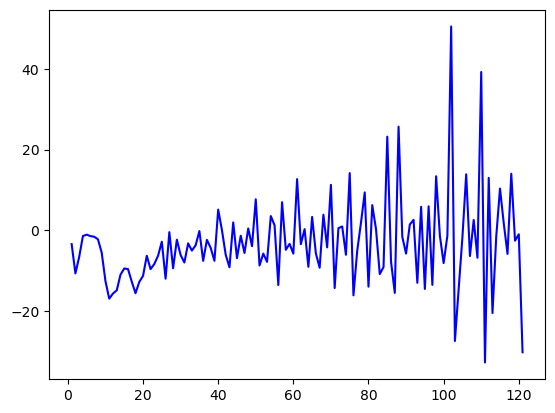

In [39]:
# For another perspective, to show the change in SSE per epoch
sse_values_B = list(SSE_tr.values())

# Calculate percent change
percent_changes_B = []
for i in range(1, len(sse_values_B)):
    prev_sse = sse_values_B[i - 1]
    curr_sse = sse_values_B[i]
    percent_change = ((curr_sse - prev_sse) / prev_sse) * 100
    percent_changes_B.append(percent_change)

# Display results
for epoch, change in enumerate(percent_changes_B, start=1):
    print(f"Epoch {epoch} to {epoch+1}: {change:.2f}% change")

plt.figure()
plt.plot(range(1, len(sse_values_B)), percent_changes_B, color = "blue")
plt.show()

# Testing

In [41]:
%%time
# Predicting the labels of the test set

act_func_A, act_func_B =  [1, 1, 0], [2, 2, 0]
prediction_A, prediction_B = [], []

for t in test:
    
    # Using Network A trained weights    
    forward_A = forprop(t, weights_A, act_func_A)
    prediction_A.append(reverse_one_hot(forward_A['y3']))
    
    # Using Network B trained weights
    forward_B = forprop(t, weights_B, act_func_B)
    prediction_B.append(reverse_one_hot(forward_B['y3']))
    
pA = pd.DataFrame(prediction_A)
pA.to_csv('predictions_for_test_tanh.csv', index = None, header = None)

pB = pd.DataFrame(prediction_B)
pB.to_csv('predictions_for_test_leakyrelu.csv', index = None, header = None)


# Show the distribution of each class using the 2 sets of trained weights
A_class_counts, B_class_counts = {}, {}
for entry in prediction_A:
    A_class_counts[entry] = A_class_counts.get(entry, 0) + 1
for entry in prediction_B:
    B_class_counts[entry] = B_class_counts.get(entry, 0) + 1

A = sorted(list(A_class_counts.keys()))
B = sorted(list(B_class_counts.keys()))
class_counts_A = {k: A_class_counts[k] for k in A}
class_counts_B = {k: B_class_counts[k] for k in B}

print("Class distribution using Network A:", class_counts_A)
print("Class distribution using Network B:", class_counts_B)

Class distribution using Network A: {1: 83, 2: 1, 4: 107, 5: 50, 6: 171, 7: 4, 8: 285}
Class distribution using Network B: {1: 80, 4: 33, 5: 39, 6: 175, 7: 14, 8: 360}
CPU times: total: 375 ms
Wall time: 76.8 ms


# Tuning the learning rate, momentum constant, and the number of neurons

OVERALL COUNT: 1
OVERALL COUNT: 2
OVERALL COUNT: 3
OVERALL COUNT: 4
OVERALL COUNT: 5
OVERALL COUNT: 6
OVERALL COUNT: 7
OVERALL COUNT: 8
OVERALL COUNT: 9
OVERALL COUNT: 10
OVERALL COUNT: 11
OVERALL COUNT: 12
OVERALL COUNT: 13
OVERALL COUNT: 14
OVERALL COUNT: 15
OVERALL COUNT: 16
OVERALL COUNT: 17
OVERALL COUNT: 18
OVERALL COUNT: 19
OVERALL COUNT: 20
OVERALL COUNT: 21
OVERALL COUNT: 22
OVERALL COUNT: 23
OVERALL COUNT: 24
OVERALL COUNT: 25
OVERALL COUNT: 26
OVERALL COUNT: 27


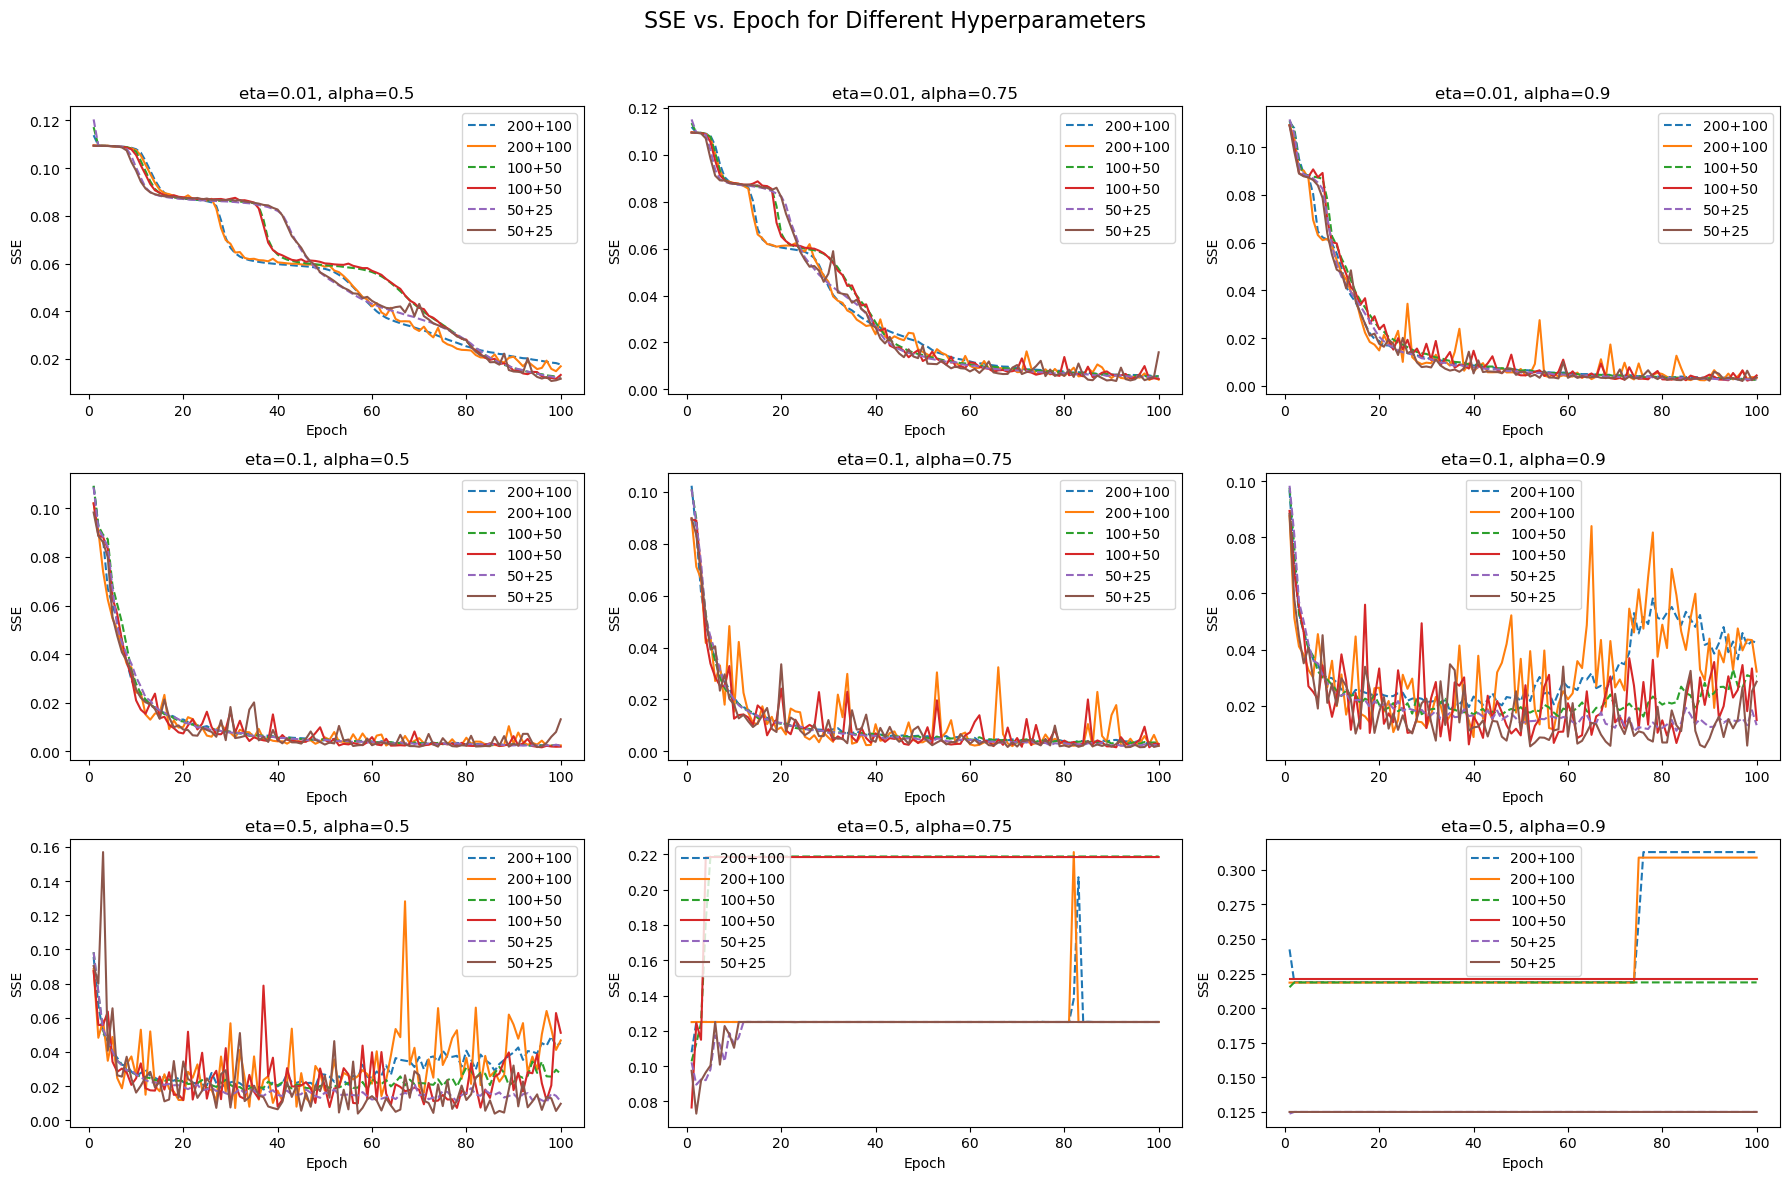

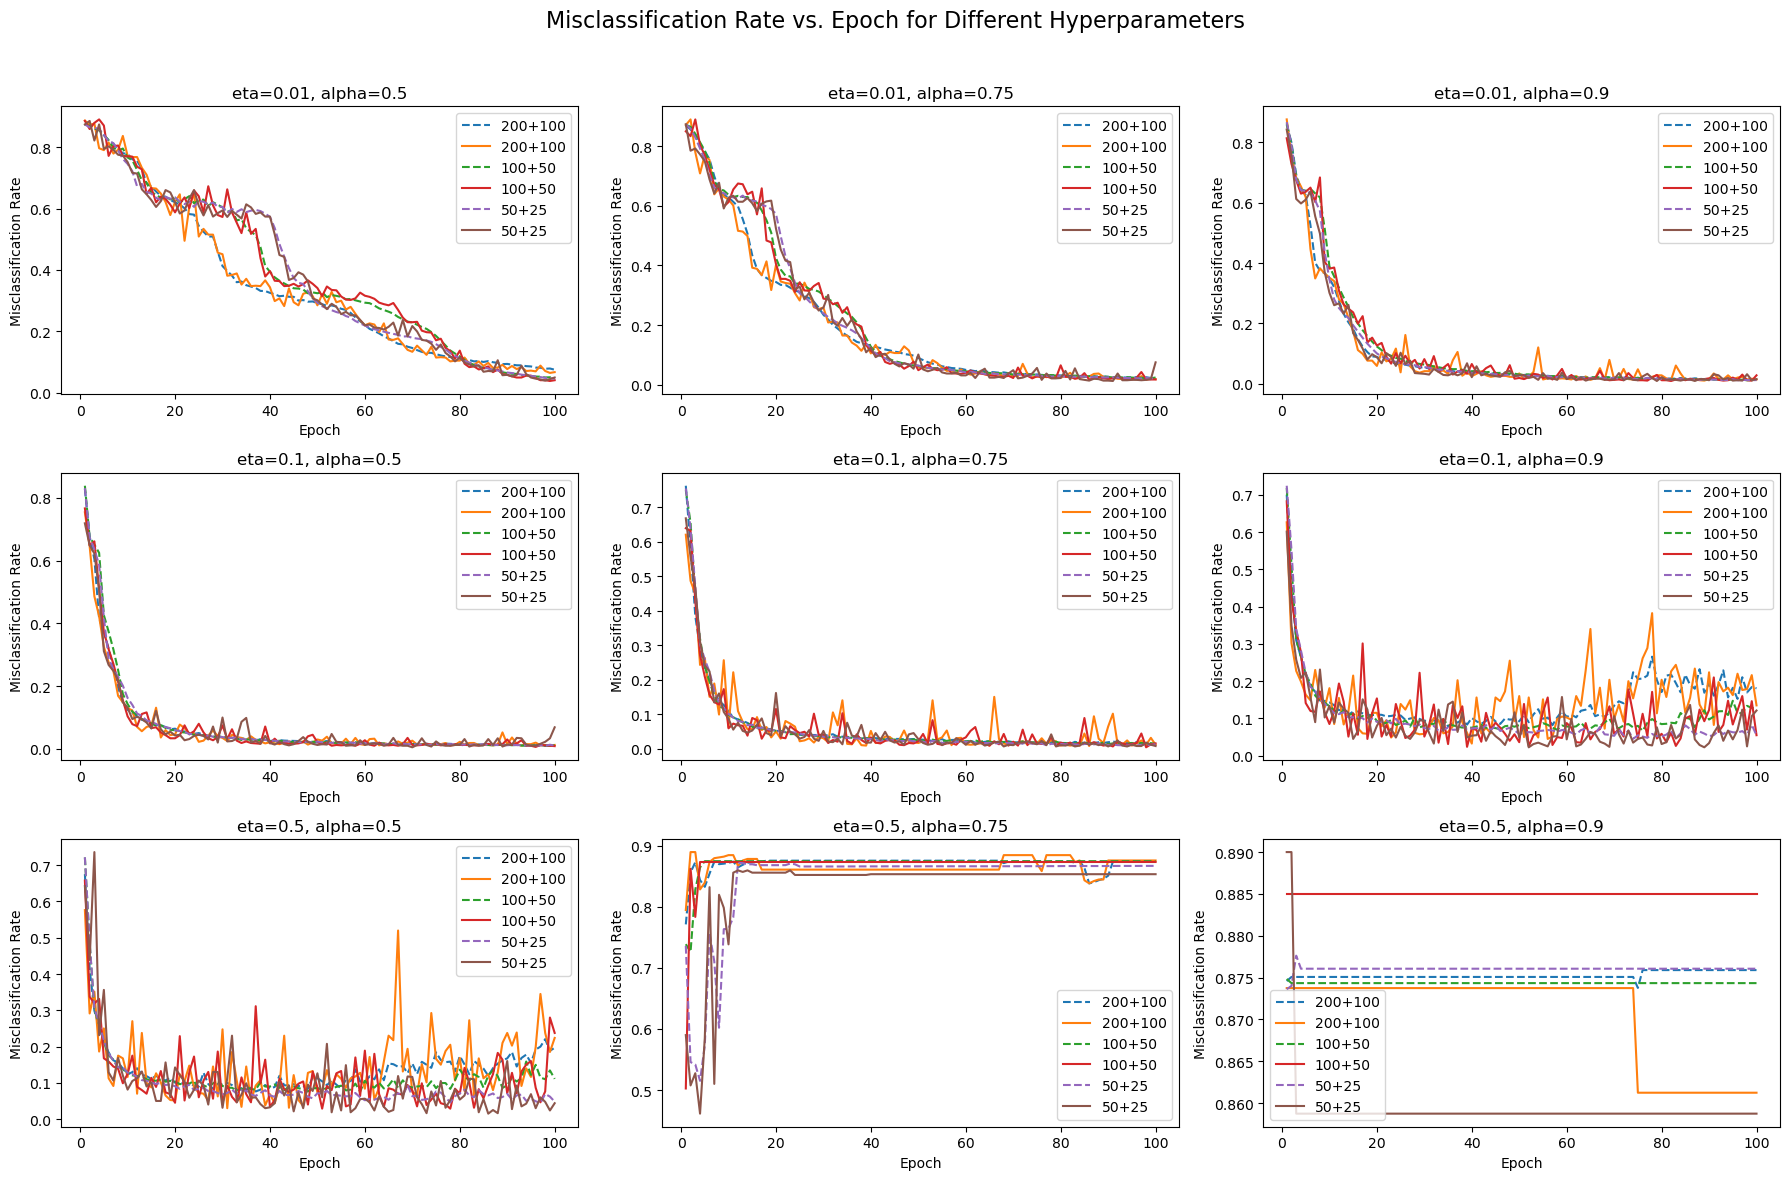

In [47]:

# To show the plots from the tuning of the hyperparameters
def plot_results(SSE_tr, SSE_val, MisClass_val, MisClass_tr, eta_s, alpha_s, hidden1_size_s, hidden2_size_s):
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("SSE vs. Epoch for Different Hyperparameters", fontsize=16)

    for i, e in enumerate(eta_s):
        for j, a in enumerate(alpha_s):
            ax = axes[i][j]
            for h in range(3):
                hidden1_size, hidden2_size = hidden1_size_s[h], hidden2_size_s[h]
                key = (e, a, h)
                epochs = list(SSE_tr[key].keys())
                t_values = list(SSE_tr[key].values())
                v_values = list(SSE_val[key].values())
                ax.plot(epochs, t_values, label=f"{hidden1_size}+{hidden2_size}", linestyle = "dashed")
                ax.plot(epochs, v_values, label=f"{hidden1_size}+{hidden2_size}")

            ax.set_title(f"eta={e}, alpha={a}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("SSE")
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Repeat for misclassification plots
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    fig.suptitle("Misclassification Rate vs. Epoch for Different Hyperparameters", fontsize=16)

    for i, e in enumerate(eta_s):
        for j, a in enumerate(alpha_s):
            ax = axes[i][j]
            for h in range(3):
                hidden1_size, hidden2_size = hidden1_size_s[h], hidden2_size_s[h]
                key = (e, a, h)
                epochs = list(MisClass_tr[key].keys())
                t_values = list(MisClass_tr[key].values())
                v_values = list(MisClass_val[key].values())
                ax.plot(epochs, t_values, label=f"{hidden1_size}+{hidden2_size}", linestyle = "dashed")
                ax.plot(epochs, v_values, label=f"{hidden1_size}+{hidden2_size}")

            ax.set_title(f"eta={e}, alpha={a}")
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Misclassification Rate")
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Testing of values to use for Network A

rand_seed = 1
eta_s = [0.01, 0.1, 0.5]
alpha_s = [0.5, 0.75, 0.9]
act_func = [1, 1, 0]
batch_size = 8
val_size = 800 
hidden1_size_s = [200, 100, 50] #initial: 181 = int(np.mean([output_size=8, input_size=354]))
hidden2_size_s = [100, 50, 25] #initial: 94 = int(np.mean([output_size=8, hidden1_size=181]))

# Load the dataset
file_data = "data.csv"
data = pd.read_csv(file_data, header = None)
data = np.array(data)

# Load the dataset labels
file_label = "data_labels.csv"
data_label = pd.read_csv(file_label, header = None)
data_label = np.array(data_label)

# Balancing the dataset
oversample = SMOTE(random_state=rand_seed)
X, y = oversample.fit_resample(data, data_label)
X, y = np.array(X), np.array(y)
Y = one_hot_encode(y, 8) # Vectorizing the label

# Combining the input and output vectors into a dictionary
new_data = {i: {'label': label, 'features': features} for i, (label, features) in enumerate(zip(Y, X))}

# Split data into train and validation
keys = list(new_data.keys())
random.Random(rand_seed).shuffle(keys) 
train_keys, val_keys = keys[val_size:], keys[:val_size]
train_dict = {k: new_data[k] for k in train_keys}
val_dict = {k: new_data[k] for k in val_keys}

train_size, val_size = len(train_keys), len(val_keys)
overall_count = 1
SSE_tr, SSE_val, MisClass_val, MisClass_tr, timer = {}, {}, {}, {}, {}

for e in eta_s: 
    for a in alpha_s:
        for h in range(3):
            eta = e
            alpha = a
            hidden1_size = hidden1_size_s[h]
            hidden2_size = hidden2_size_s[h]
            key = (e, a, h)
            
            print(f"OVERALL COUNT: {overall_count}")
            overall_count += 1
            
            # Start the timer
            start_time = time.time()
            
            # Initialize
            np.random.seed(rand_seed)
            input_size = X.shape[1]
            output_size = Y.shape[1]
            weights = {
                'w1' : np.random.rand(hidden1_size, input_size)*0.01,
                'b1' : np.random.rand(hidden1_size,)*0.01,
                'w2' : np.random.rand(hidden2_size, hidden1_size)*0.01,
                'b2' : np.random.rand(hidden2_size,)*0.01,
                'w3' : np.random.rand(output_size, hidden2_size)*0.01,
                'b3' : np.random.rand(output_size,)*0.01,
                }
            
            # Training
            epoch, batch, err, val_err = 1, 0, 0, 0
            t_counter, v_counter = 0, 0
            sum_dw_db = {}
            prev_SSE, t_change_SSE = 1, 1
            prev = {
                'dw1': np.zeros_like(weights['w1']),
                'db1': np.zeros_like(weights['b1']),
                'dw2': np.zeros_like(weights['w2']),
                'db2': np.zeros_like(weights['b2']),
                'dw3': np.zeros_like(weights['w3']),
                'db3': np.zeros_like(weights['b3']),
                }
            rand = 1
            #while prev_SSE > 0.001:
            while epoch < 101:
            
                # One epoch
                for ki, value in train_dict.items():
                    x = value['features']
                    d = value['label']
            
                    # Forward and Backpropagation
                    forward = forprop(x, weights, act_func)
                    back = backprop(x, d, weights, forward, eta, prev, alpha, act_func)
                    err += np.mean(back['e']**2)
                    prev = back
            
                    # Storing the delta values of the weights
                    for k, v in back.items():
                        if k not in sum_dw_db:
                            sum_dw_db[k] = v
                        else:
                            sum_dw_db[k] += v
            
                    # Updating the weights
                    batch += 1
                    if batch == batch_size:
                        dw1, db1, dw2, db2, dw3, db3 = sum_dw_db['dw1'], sum_dw_db['db1'], sum_dw_db['dw2'], sum_dw_db['db2'], sum_dw_db['dw3'], sum_dw_db['db3']
                        w1, b1, w2, b2, w3, b3 = weights['w1'], weights['b1'], weights['w2'], weights['b2'], weights['w3'], weights['b3']
                        sum_dw_db = {}
                                                
                        weights = {
                            'w1' : w1 + dw1 * (1/batch),
                            'b1' : b1 + db1 * (1/batch),
                            'w2' : w2 + dw2 * (1/batch),
                            'b2' : b2 + db2 * (1/batch),
                            'w3' : w3 + dw3 * (1/batch),
                            'b3' : b3 + db3 * (1/batch)
                            }
                        batch = 0
                    
                    act = reverse_one_hot(d)
                    pred = reverse_one_hot(forward['y3'])
                    t_counter += (pred != act) + 0
                    
                # Validation for every 5th epoch
                if epoch % 1 == 0: # currently done for every epoch for checking
                    for k, v in val_dict.items():
                        x = v['features']
                        d = v['label']
                
                        # Forward and Error Calculation
                        forward = forprop(x, weights, act_func)
                        val_e = d - forward['y3']
                        val_err += np.mean(val_e**2)
            
                        # Misclassification Calculation
                        act = reverse_one_hot(d)
                        pred = reverse_one_hot(forward['y3'])
                        v_counter += (pred != act) + 0
            
                    if key not in SSE_val:
                        SSE_val[key] = {epoch: val_err/val_size}
                    if key in SSE_val:
                        SSE_val[key][epoch] = val_err/val_size
                   
                    if key not in MisClass_val:
                        MisClass_val[key] = {epoch: v_counter/val_size}
                    if key in MisClass_val:
                        MisClass_val[key][epoch] = v_counter/val_size
                    
                    val_err, v_counter = 0, 0
            
                
                # Recording the average SSE and misclassification rate for the epoch and resetting        
                if key not in SSE_tr:
                    SSE_tr[key] = {epoch: err/train_size}
                if key in SSE_tr:
                    SSE_tr[key][epoch] = err/train_size
                
                if key not in MisClass_tr:
                    MisClass_tr[key] = {epoch: t_counter/train_size}
                if key in MisClass_tr:
                    MisClass_tr[key][epoch] = t_counter/train_size
                
                t_change_SSE = abs(prev_SSE - SSE_tr[key][epoch]) / prev_SSE
                prev_SSE = err/train_size
                err, t_counter = 0, 0
                epoch += 1
                
                # Reshuffling the training and validation data for the next epoch
                random.Random(rand).shuffle(train_keys) 
                train_d = {k: train_dict[k] for k in train_keys}
                train_dict = train_d
                rand += 1
            
                if epoch == 500: # early stopping criterion
                    break
            
            # Stop the timer
            end_time = time.time()
            if key not in timer:
                timer[key] = {epoch: end_time - start_time}
            if key in timer:
                timer[key][epoch] = end_time - start_time

# Show the results through plots
plot_results(SSE_tr, SSE_val, MisClass_val, MisClass_tr, eta_s, alpha_s, hidden1_size_s, hidden2_size_s)
